In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from collections import defaultdict
from functools import reduce

In [2]:
################################
class ClassCounter:
    def __init__(self, subject):
        #initialize the subject name
        self.subject = subject

    def prepare(self, class_num):
        #initialize the array which is to count how many elements are there in each class
        #initialize the array which store the percentage of numbers of each class in the total numbers of instance
        self.__classes_count = [0] * class_num
        self.__classes_prob = [0] * class_num
        
    def add(self, class_index):
        #count how many elements are there in each class
        self.__classes_count[class_index] += 1
    
    def run(self):
        #calculate how many elements are there in total 
        total = sum(self.__classes_count)
        #calculate the percentage of numbers of each class in the total numbers of instance
        for index, val in enumerate(self.__classes_count):
            self.__classes_prob[index] = val/total
    
    def get(self):
        #return the percentage of numbers of each class in the total numbers of instance
        return tuple(self.__classes_prob)
    
    def get_classes_count(self):
        #return how many elements are there in each class
        return self.__classes_count

In [3]:
#Father class to count the elements of attribute
class AttrCounter:
    def __init__(self, name):
        #store the name of the attribute 
        self.name = name

    def prepare(self, class_num):
        #initialize the container to store the elements
        return
    
    def add(self, attr, class_index):
        #precess the dataset and instore the elements in to the container that initialized in thre prepare function
        return 
    
    def run(self):
        #calculate the precentage
        return 
    
    def get(self, attr):
        #returm the precentage
        return 0

In [4]:
#son class to counter the elemnts of nominal attibute
class NomCounter(AttrCounter):
    __smooth_alpha = 1
    
    def __init__(self, name):
        #store the name of this attribute
        super().__init__(name)

    def prepare(self, class_num):
        #store all the possible values of an attribute in a set
        self.__attr_vals = set()
        #for each class values, create a dictionary to store the corresponding numbers of this attribute values
        self.__attr_count = [defaultdict(int) for i in range(class_num)]
        #for each class values, create a dictionary to store the corresponding precentage of this attribute values(the target value)
        self.__attr_prob = [defaultdict(float) for i in range(class_num)]
    
    def add(self, attr, class_index):
        #add the attribute values
        self.__attr_vals.add(attr)
        #add the number of attribute value in corresponding class
        self.__attr_count[class_index][attr] += 1
    
    def run(self):
        #number of attribute in the dataset
        dimension = len(self.__attr_vals)
        #to calculate the precentage of each attribute value precentage in this particular class
        for index, attrs in enumerate(self.__attr_count):
            total = reduce(lambda x, y: x + y, attrs.values())
            for val in self.__attr_vals:
                self.__attr_prob[index][val] = self._laplace_smooth(attrs[val], total, dimension)
    
    def get(self, attr): 
        #return the precentage
        return tuple(prob[attr] for prob in self.__attr_prob)
    
    #use Laplace smoothing to replace the zero value
    def _laplace_smooth(self, num, total, dimension):
        return (num+self.__smooth_alpha)/(total+dimension*self.__smooth_alpha)

In [5]:
#son class to counte the element of the numberical attributes
class NumCounter(AttrCounter):
    
    def __init__(self, name):
        #store the name of this attribute
        super().__init__(name)

    def prepare(self, class_num):
        #for each class, create the container to store the corresponding attribute values
        self.__attr_data = [[] for i in range(class_num)]
        #for each class,calculate the mean of this attribute(the target value)
        self.__mean = [0] * class_num
        #for each class, calculate the deviation of this attribute(the target value)
        self.__deviation = [0] * class_num
    
    def add(self, attr, class_index):
        #to store all the values into the container
        self.__attr_data[class_index].append(float(attr))
    
    def run(self):
        #use the values that stored in the container to calculate the mean values adn deviation values 
        for index, data in enumerate(self.__attr_data):
            #calculate the mean value
            mean = sum(data)/len(data)
            #calculate the deviation values
            deviation = math.sqrt(sum([(x - mean)**2 for x in data])/(len(data)-1))
            #set the mean inside the class
            self.__mean[index] = mean
            #set the deviation inside the class
            self.__deviation[index] = deviation
    
    def get(self, attr):
        #return the normal distribution
        return tuple(self._normal_distribution(float(attr), self.__mean[i], self.__deviation[i]) for i in range(len(self.__mean)))
    
    def _normal_distribution(self, val, mean, deviation):
        ###to calculate the normal distribution
        return 1/(deviation*math.sqrt(2*math.pi))*np.exp(-((val-mean)/deviation)**2/2) if deviation > 0 else 0
    
    def draw_histogram(self):
        ##################
        bin_size = 20#####
        ##################
        plt.figure()
        for i, values in enumerate(self.__attr_data):
            plt.hist(values, bins = bin_size,color = 'cyan', edgecolor = 'k', label = 'historgram') 
            plt.title(self.name+' class'+str(i))
            plt.show()
        
    def draw_box_plot(self):
        figure,axes=plt.subplots() #得到画板、轴
        axes.boxplot(self.__all_values,patch_artist=True) #描点上色
        plt.show()
    
    

In [6]:
class Num2NomCounter(NomCounter):  
    def __init__(self, name, bins):
        assert(bins >= 2)
        super().__init__(name)
        self.__bins = bins

    def prepare(self, class_num):
        self.__split = [0] * (self.__bins-1)
        self.__attr_data = []
        self.__attr_count = [[0]*self.__bins for i in range(class_num)]
        self.__attr_prob = [[0]*self.__bins for i in range(class_num)]
    
    def add(self, attr, class_index):
        self.__attr_data.append((float(attr), class_index))
    
    def run(self):
        self.__attr_data.sort()
        gaps = self.__split_integer(len(self.__attr_data),self.__bins)
        cur = 0
        for i in range(self.__bins-1):
            npos = sum(gaps[:i+1])
            self.__split[i] = self.__attr_data[npos][0]
            for j in range(cur, npos):
                self.__attr_count[self.__attr_data[j][1]][i] += 1
            cur = npos
        for j in range(cur, len(self.__attr_data)):
            self.__attr_count[self.__attr_data[j][1]][i+1] += 1           
        for index,attrs in enumerate(self.__attr_count):
            total = reduce(lambda x, y: x + y, attrs)
            for val, num in enumerate(attrs):
                self.__attr_prob[index][val] = self._laplace_smooth(num, total, self.__bins)
    
    def get(self, attr):
        attr = float(attr)
        for i in range(self.__bins):
            if i >= len(self.__split) or attr < self.__split[i]:
                break
        return tuple(prob[i] for prob in self.__attr_prob)
    
    def __split_integer(self, m, n):
        quotient = int(m / n)
        remainder = m % n
        if remainder > 0:
            return [quotient] * (n - remainder) + [quotient + 1] * remainder
        if remainder < 0:
            return [quotient - 1] * -remainder + [quotient] * (n + remainder)
        return [quotient] * n

In [7]:
class Nom2NumCounter(NumCounter):
    def __init__(self, name, mapper):
        super().__init__(name)
        self.__mapper = mapper
    
    def add(self, attr, class_index):
        self._attr_data[class_index].append(self.__mapper(attr))

In [8]:
class Evaluation:
#     num_of_class = 0
#     num_of_inst = 0
#     result = []
#     multiclass_matrix=None
#     correct_pre = []
#     actual_num = []
#     predict_num = []
    
    def __init__(self,result,num_of_class):
        #the input(list of tuples, tuple has two value, first one is real class value, second is the predict one)
        self.result = result
        #number of class
        self.num_of_class = num_of_class
        #number of instances
        self.num_of_inst = len(result)
        #generate the muticlass matrix(that mentions in the lecture slide)
        self.multiclass_matrix = self.generate_matrix()
        #use the multiclass matrix to generte some value that we need to evaluate the model
        self.precess_matrix()
    
    def generate_matrix(self):
        matrix = np.zeros((self.num_of_class, self.num_of_class))
        for tup in self.result:
            matrix[tup[0]][tup[1]]+=1
        return matrix
    
    def precess_matrix(self):
        #fill in these array 
        #the values on the matrix diagonal, how many numbers of instance that the model correctly predict for this particular class
        self.correct_pre = [self.multiclass_matrix[i][i] for i in range(self.num_of_class)]
        #the actual numbers of instance that each class has in this dataset(TP+FN)
        self.actual_num = [self.multiclass_matrix[i].sum() for i in range(self.num_of_class)]
        #all numbers of instance that we predict for each class(TP+FP)
        self.predict_num = [self.multiclass_matrix[:,i].sum() for i in range(self.num_of_class)]
    
    
    def calculate_accuracy(self):
        #calculate the accuracy
        accuracy = sum(self.correct_pre)/sum(self.actual_num)
        return accuracy
    
    def calculate_Macro_value(self):   
        ###precision###
        temp_arr1 = []
        #calculate the precision by its formula
        for i in range(self.num_of_class):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.predict_num[i]==0):
                temp_arr1.append(0)
            else:
                this_pre = self.correct_pre[i]/self.predict_num[i]
                temp_arr1.append(this_pre)
        precision = sum(temp_arr1)/self.num_of_class
            
        ###recall###
        temp_arr2 = []
        #calculate the recall by its formula
        for i in range(self.num_of_class):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.actual_num[i]==0):
                temp_arr2.append(0)
            else:
                this_recall = self.correct_pre[i]/self.actual_num[i]
                temp_arr2.append(this_recall)
        recall = sum(temp_arr2)/self.num_of_class
        
        return [precision, recall]
    
    
    def calculate_Micro_value(self):
        ###precision###
        precision = sum(self.correct_pre)/sum(self.predict_num)
        ###recall###
        recall = sum(self.correct_pre)/sum(self.actual_num)
        return [precision, recall]
    
    def calculate_weight_value(self):
        ###precision###
        temp_arr1 = []
        #calculate the precision by its formula
        for i in range(self.num_of_class):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.predict_num[i]==0):
                temp_arr1.append(0)
            else:
                this_pre = (self.actual_num[i]/self.num_of_inst)*(self.correct_pre[i]/self.predict_num[i])
                temp_arr1.append(this_pre)
        precision = sum(temp_arr1)     
        ###recall###
        temp_arr2 = []
        #calculate the recall by its formula
        for i in range(self.num_of_class):
            #if there is any value is 0, then store 0(otherwise, denominator will be zero)
            if(self.correct_pre[i]==0 or self.actual_num[i]==0):
                temp_arr2.append(0)
            else:
                this_recall = (self.actual_num[i]/self.num_of_inst)*(self.correct_pre[i]/self.actual_num[i])
                temp_arr2.append(this_recall)
        recall = sum(temp_arr2)
        
        return [precision, recall]
        
        
    def draw_heatmap_d(self):
        #draw the heatmap with numbers of instance on it
        sns.heatmap(self.multiclass_matrix, vmin=0, vmax=len(self.result), annot=True,cmap="RdPu_r", fmt='.20g')
        plt.show()
        
    def draw_heatmap_f(self):
        #draw the heatmap with precentage on it
        sns.heatmap(self.multiclass_matrix/len(self.result), vmin=0, vmax=1, annot=True,cmap="RdPu_r", fmt='.2g')
        plt.show()  
        
    def draw_bar_chart(self):
        #draw the bar chart
        #for each class
        #show the numbers of predict value, actual value, correctly predict value
        names = ["calss"+str(i) for i in range(self.num_of_class)]
        plt.figure(figsize=(10,6), dpi=80)
        x = range(len(names))
        
        plt.bar(x, self.actual_num, width=0.1)
        plt.bar([i + 0.1 for i in x], self.predict_num, width=0.1)
        plt.bar([i + 0.2 for i in x], self.correct_pre, width=0.1)

        plt.xticks([i + 0.05 for i in x], names)
        
        plt.xlabel('Class Name', fontsize=14)
        plt.ylabel('Number Of Each Class', fontsize=14)
        plt.show()
        
        
    def evaluate(self):
        ################################Calculate Accuracy##################################
        accuracy = self.calculate_accuracy()
        #print(self.correct_pre,self.actual_num, self.predict_num)
        print("accuracy is: %f" %accuracy)
        print("error rate is: %f"%(1-accuracy))

        ##macro averaging
        precisionMa, recallMa = self.calculate_Macro_value()
        print("\n----------------the macro averaging way------------------")
        print("Marco averaging precision is: ",precisionMa)
        print("Marco averaging recall is:",recallMa)
        
        #micro averaging
        precisionMi, recallMi = self.calculate_Micro_value()
        print("----------------the micro averaging way------------------")
        print("Mirco averaging precision is:", precisionMi)
        print("Mirco averaging recall is:", recallMi)
        
        #weight averaging
        precisionWe, recallWe = self.calculate_weight_value()
        print("----------------the weight averaging way------------------")
        print("weight averaging precision is:" ,precisionWe)
        print("weight averaging recall is:" ,recallWe)
        
        ###################################Draw Graphs######################################
        #self.draw_heatmap_d()
        #self.draw_heatmap_f()
        #self.draw_bar_chart()
        
        

In [14]:
class Model:
    def __init__(self, classes, *counters):
        self.num = 10
        #convert the class name(string) into the number(start from 0), like class name1 = 0, class name2 = 1, class name3 = 2, etc.
        return_value = '''eg. {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}'''
        self.__classes = {classname:index for index,classname in enumerate(classes)}
        #it is a tuple to store all initialized particular attribute(in the particular type class)
        self.__counters = counters
        #initialize the filters
        self.__filters = ()
        #to judge whether we need to delete the first column (some time the first colum is the serial number)
        self.__dump_firt_column = False
        for index, counter in enumerate(counters):
            #if the counter is a class type counter
            if isinstance(counter, ClassCounter):
                #set the position of the target class column in this Model class 
                self.__classpos = index
            #use the function in the class to prepare the each attribute  (which is initialze all the attributes values container)
            counter.prepare(len(classes))
            
    def set_filters(self, filters):
        #set the particular filters
        #because different datasets has different punctuation to represent the missing value
        #so we need to set the particular filters to particular punctuation
        self.__filters = filters
        
    def set_dump_firt_column(self, enabled):
        #set whether we need to delete the first column (some time the first colum is the serial number)
        self.__dump_firt_column = enabled
            
    def preprocess(self, lines):
        #we will read the file line by line, so that we gonna preprocess the data line by line
        for line in lines:
            #split all the data in a line
            inputs = line.strip().split(",")[1:] if self.__dump_firt_column else line.strip().split(",")
            #if we successfully read the file lines into the program, continue running this preprocess function
            if not inputs or not inputs[0]:
                continue
                
            ###DEALING WITH CLASS VALUE###
            #find out the class value of this instance
            class_index = self.__classes[inputs[self.__classpos]]
            ###DEALING WITH EACH ATTRIBUTE VALUE
            #read in all the values and use their particular way to store into their value container 
            for i, val in enumerate(inputs):
                ########!!!!!########
                #if there is no missing value, continue store the instance inside the attribute class container, 
                #otherwise discard this attribute (we choose this way to deal with the missing value which will explain in the written example)
                if val not in self.__filters:
                    #if this is the value of the target class
                    if i == self.__classpos:
                        #add value in the ClassCounter
                        self.__counters[i].add(class_index)
                    else:
                        #otherwise add value in their own AttriCounter
                        self.__counters[i].add(val, class_index)
                
    def train(self):
        #train the training set by running the function in their class
        for counter in self.__counters:
            counter.run()

    def test(self, lines):
        res = []
        #we still need to read the file line by line, so that we gonna preprocess the test data line by line
        for line in lines:
            #split all the data in the line
            inputs = line.strip().split(",")[1:] if self.__dump_firt_column else line.strip().split(",")
            #if we successfully read the file lines into the program, continue running this preprocess function 
            if not inputs or not inputs[0]:
                continue
            
            #real target class type of this instance
            real = self.__classes[inputs[self.__classpos]]
            #all the predict value 
            predict = []
            
            for i, val in enumerate(inputs):
                #if there is no missing value, continue store the instance inside the attribute class container, 
                #otherwise discard this attribute (we choose this way to deal with the missing value which will explain in the written example)
                if val not in self.__filters:
                    #caluculate the presentage that each type that this instance might have
                    if i == self.__classpos:
                        predict.append(np.log2(np.array(self.__counters[i].get())))
                    else:
                        predict.append(np.log2(np.array(self.__counters[i].get(val))))
            #store the real value and our predict value in a tuple(real value, predict value)
            res.append((real, np.argmax(reduce(lambda x, y: x+y, predict))))
        return res
    
    def train_zero_R_baseline(self):
        for counter in self.__counters:
            #if the counter is a class type counter
            if isinstance(counter, ClassCounter):
                #get the each number of times class happened at dataset(which store at the ClassCounter) eg.[3630(class0), 1152(class1), 207(class2), 195(class3)]
                self.__class_count = counter.get_classes_count()
                #find out the class that happened for most of time
                maximum_class = self.__class_count[0]
                #return its index(which is the index that represent the class)
                self.___majority_class_index = 0
                #start to find that class
                for i in range(len(self.__class_count)):
                    if(self.__class_count[i]>maximum_class):
                        maximum_class = self.__class_count[i]
                        self.___majority_class_index = i
                        
    def test_zero_R_baseline(self, lines):
        res = []
        #we still need to read the file line by line, so that we gonna preprocess the test data line by line
        for line in lines:
            #split all the data in the line
            inputs = line.strip().split(",")[1:] if self.__dump_firt_column else line.strip().split(",")
            #if we successfully read the file lines into the program, continue running this preprocess function 
            if not inputs or not inputs[0]:
                continue
            #real target class type of this instance
            real = self.__classes[inputs[self.__classpos]]
            #and predict all the class value of test instance as the class that occur for the most of time
            res.append((real,self.___majority_class_index))
        return res
    
    def graw_attr_distribution(self):
        for counter in self.__counters:
            if isinstance(counter, NumCounter):
                counter.draw_histogram()
                
    def evaluate(self,result, classes):
        evaluate_result = Evaluation(result, len(classes))
        evaluate_result.evaluate()   
        return evaluate_result
        

In [15]:
def compare_two_evaluation_class(evaluation1, evaluation2):
        #generate the value throught the function inside the Evaluation class
        accuracy1 = evaluation1.calculate_accuracy()
        accuracy2 = evaluation2.calculate_accuracy()
        precision1,recall1 = evaluation1.calculate_Macro_value()
        precision2,recall2 = evaluation2.calculate_Macro_value()
        
        
        #generate the x-axis
        value_names = ['accuracy', 'precision','recall']
        #generate the two y-axis
        values1 = [accuracy1,precision1,recall1]
        values2 = [accuracy2,precision2,recall2]
        
        
        #draw the bar chart
        plt.figure(figsize=(10,6), dpi=80)
        x = range(len(value_names))

        m1 = plt.bar(x, values1, width=0.1)
        m2 = plt.bar([i + 0.1 for i in x], values2, width=0.1)

        plt.xticks([i + 0.05 for i in x], value_names)
        #draw the legend
        plt.legend((m1,m2),("Navie Bayes Classifier","Baseline"), loc="upper right")
        
        #lable the value
        def autolabel(rects): 
            for rect in rects:
                height = rect.get_height()
                plt.text(rect.get_x()+rect.get_width()/2., 1.03*height, '%s' % float(height))

        autolabel(m1)
        autolabel(m2)
        
        #label x and y axis name
        plt.xlabel('value name', fontsize=14)
        plt.ylabel('precentage', fontsize=14)
        #show the figure
        plt.show()
        
#compare_two_evaluation_class(normal_method, baseline_method)

In [65]:
###11. Wine Dataset - numeric only###
####################################################################################################
filename = "datasets/wine.data"
classes = ("1" , "2", "3")
thisClassCounter = ClassCounter("Alcohol"),
model = Model(
    classes,
    thisClassCounter,
    NumCounter("age"),
    NumCounter("Malic acid"),
    NumCounter("Ash"),
    NumCounter("Alcalinity of ash"),
    NumCounter("Magnesium"),
    NumCounter("Total phenols"),
    NumCounter("Flavanoids"),
    NumCounter("Nonflavanoid phenols"),
    NumCounter("Proanthocyanins"),
    NumCounter("Color intensity"),
    NumCounter("Hue"),
    NumCounter("OD280/OD315 of diluted wines"),
    NumCounter("Proline")
)

In [66]:
#weight averaging precision is: 0.871943
#weight averaging recall is: 0.715856
with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train()
    result = model.test(lines)
    normal_method = model.evaluate(result, classes)

thisClassCounter =  

accuracy is: 0.988764
error rate is: 0.011236

----------------the macro averaging way------------------
Marco averaging precision is:  0.9885024432308134
Marco averaging recall is: 0.9896554468051245
----------------the micro averaging way------------------
Mirco averaging precision is: 0.9887640449438202
Mirco averaging recall is: 0.9887640449438202
----------------the weight averaging way------------------
weight averaging precision is: 0.9888786975464341
weight averaging recall is: 0.9887640449438202


In [67]:
with open(filename,"r") as file:
    lines = file.readlines()
    model.preprocess(lines)
    model.train_zero_R_baseline()
    result = model.test_zero_R_baseline(lines)
    baseline_method = model.evaluate(result, classes)
    

accuracy is: 0.398876
error rate is: 0.601124

----------------the macro averaging way------------------
Marco averaging precision is:  0.13295880149812733
Marco averaging recall is: 0.3333333333333333
----------------the micro averaging way------------------
Mirco averaging precision is: 0.398876404494382
Mirco averaging recall is: 0.398876404494382
----------------the weight averaging way------------------
weight averaging precision is: 0.15910238606236585
weight averaging recall is: 0.398876404494382


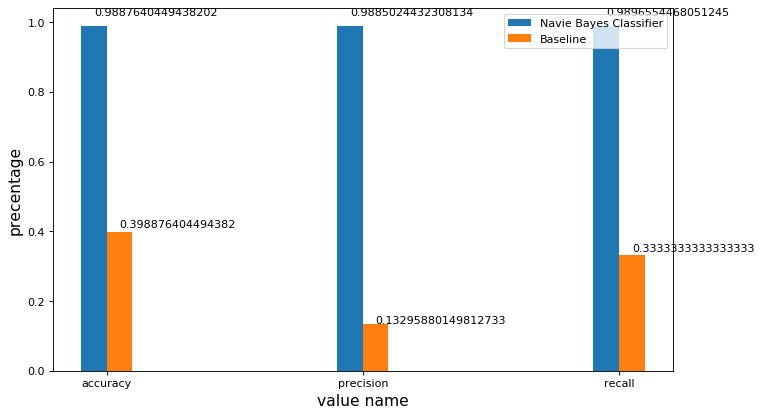

In [68]:
compare_two_evaluation_class(normal_method, baseline_method)